In [1]:
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
import os
import sys
from data import CIFAR_gen
from models import joint, augmentor, encoder, baseline
import torch.optim as optim


join = os.path.join

bs = 100 

cgen = CIFAR_gen(bs=bs)

LEN:  50000
LEN:  10000


In [ ]:
m = joint(shape=cgen.train_shape[1:])
opt = optim.Adam(m.parameters())

In [ ]:
for i, (x,y) in enumerate(cgen.generator(train=True)):
    
    opt.zero_grad()
    
    (_, _, encoder_loss), (_, augmentor_loss) = m.evaluate(x)
    
    loss = -encoder_loss * torch.log(augmentor_loss)
    
    loss.backward()
    opt.step()
    print(loss.detach().numpy(), encoder_loss.detach().numpy(), augmentor_loss.detach().numpy(), )

In [178]:
def warp_sample(x,
                divisions=5,
                sf=1):
    
    if type(x) == torch.Tensor:
        torch_tensor = True
        x = x.permute(-1,-2,-3).detach().numpy()
    
    x = 255 * x
    x = x.astype(np.uint8)
    
    rows, cols = x.shape[0], x.shape[1]
    
    src_cols = np.linspace(0, cols, divisions)
    src_rows = np.linspace(0, rows, divisions)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]
    
    f = max(x.shape) // (2 * (divisions - 1) ) - sf

    dst_rows = src[:, 1] + f * np.random.random(src[:, 1].shape) - f/2
    dst_cols = src[:, 0] + f * np.random.random(src[:, 0].shape) - f/2

    dst = np.vstack([dst_cols, dst_rows]).T

    tform = PiecewiseAffineTransform()
    tform.estimate(src, dst)

    crop_dist = 0#f//2
    out = warp(x, tform)#[crop_dist:-crop_dist,crop_dist:-crop_dist,:]
    
    if torch_tensor:
        return torch.Tensor(out).permute(-1,-2,-3).type(torch.float) / 255.0
    
    return out


def preproc(batch, fns, serial=True):
    
    if serial:
        for i, sample in enumerate(batch):
            for fn in fns:
                batch[i] = fn(sample)
    
    else:
        for fn in fns:
            batch = fn(batch)
            
    return batch

In [179]:
# vanilla CNN, a close equivalent

base = baseline()
opt = optim.Adam(base.parameters())
loss_fn = torch.nn.MSELoss()

n_epochs = 30

In [ ]:
preproc_fns = [warp_sample]

for epoch in range(n_epochs):
    
    train_loss = 0
    
    for i, (x,y) in enumerate(cgen.generator(train=True)):
        
        x = preproc(x, preproc_fns)

        opt.zero_grad()

        out = base(x)

        loss = loss_fn(out, F.one_hot(y).float())
        train_loss += loss.item()

        loss.backward()
        opt.step()

    train_loss /= i * bs

    val_loss = 0
    val_acc = 0

    for i, (x,y) in enumerate(cgen.generator(train=False)):

        with torch.no_grad():
            out = base(x)
            val_loss += loss_fn(out, F.one_hot(y).float()).item()
            val_acc += torch.sum(torch.argmax(out, axis=1) == y).item()
    
    val_loss /= i * bs
    val_acc /= i * bs

    print(f'epoch #{epoch+1}\t\
            train_loss:\t{train_loss:3f}\t\
            val_loss:\t{val_loss:3f}\t\
            val_acc:\t{val_acc:3f}')

epoch #1	            train_loss:	0.000895	            val_loss:	0.001432	            val_acc:	0.102424


In [1]:
i = 1
sample = m.a(x)[i][0].detach().numpy()
sample -= sample.min()
sample /= sample.max()
plt.imshow(sample), y[i].detach().numpy()[0]

NameError: name 'm' is not defined

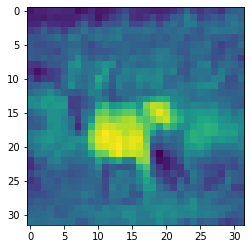

In [6]:
gt = x[i][0].detach().numpy()
plt.imshow(gt)

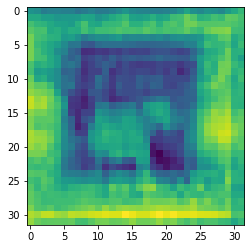

In [7]:
plt.imshow(gt-sample)

In [10]:
gt.min(), gt.max(), sample.min(), sample.max(), torch.nn.MSELoss()(m.a(x)[i][0], x[i][0]).item(), torch.nn.MSELoss()(m.a(x)[i][0], m.a(x)[i-1][0]).item()

NameError: name 'sample' is not defined

In [14]:
[k for k in [*m.state_dict().keys()] if k[0]=='e']

['e.c1.weight',
 'e.c1.bias',
 'e.c2.weight',
 'e.c2.bias',
 'e.c3.weight',
 'e.c3.bias',
 'e.c4.weight',
 'e.c4.bias',
 'e.c5.weight',
 'e.c5.bias',
 'e.fc1.weight',
 'e.fc1.bias',
 'e.fc2.weight',
 'e.fc2.bias']

In [6]:
i3 = torchvision.models.inception_v3()
i3.load_state_dict(torch.load('inception_v3_google-0cc3c7bd.pth'))

<All keys matched successfully>

In [17]:
sample = torch.Tensor(cv2.resize(cv2.imread('DSC_5908.jpg', cv2.IMREAD_GRAYSCALE), (28,28))).reshape((1,1,28,28))
sample.size()

torch.Size([1, 1, 28, 28])

(array([ 1.,  0.,  2.,  3.,  3., 13., 18., 32., 33., 48., 52., 55., 46.,
        64., 79., 68., 56., 53., 35., 48., 40., 37., 20., 20., 25., 19.,
        21., 15., 17., 17.,  6.,  9.,  6., 12., 10.,  3.,  4.,  0.,  2.,
         1.,  1.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([-2.6350012 , -2.4827774 , -2.3305538 , -2.17833   , -2.0261064 ,
        -1.8738825 , -1.7216588 , -1.5694351 , -1.4172114 , -1.2649877 ,
        -1.112764  , -0.96054024, -0.8083165 , -0.6560928 , -0.5038691 ,
        -0.35164538, -0.19942166, -0.04719793,  0.10502579,  0.2572495 ,
         0.40947324,  0.56169695,  0.71392065,  0.8661444 ,  1.0183681 ,
         1.1705918 ,  1.3228155 ,  1.4750392 ,  1.627263  ,  1.7794867 ,
         1.9317105 ,  2.083934  ,  2.236158  ,  2.3883815 ,  2.5406053 ,
         2.6928291 ,  2.8450527 ,  2.9972765 ,  3.1495001 ,  3.301724  ,
         3.4539475 ,  3.6061714 ,  3.7583952 ,  3.9106188 ,  4.0628424 ,
         4.2150664 ,  4.36729   ,  4.5195136 ,  4.671737  ,

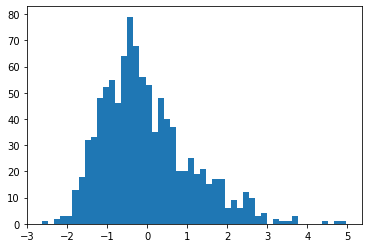

In [101]:
plt.hist(i3.eval()(sample).reshape((1000)).detach().numpy(), bins=50)

In [96]:
i3.state_dict()['Conv2d_1a_3x3.conv.weight'].shape

torch.Size([32, 3, 3, 3])

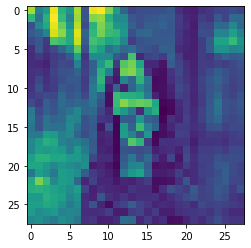

In [19]:
plt.imshow(sample[0].reshape(28,28,1).int())

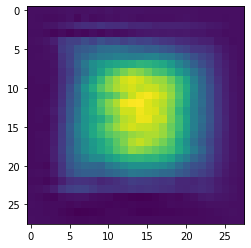

In [23]:
plt.imshow(m.a(sample)[0][0].detach().numpy())

In [4]:
xxx = aug(torch.Tensor(np.random.random((2,1,28,28))))

> /Users/work/Git/unsupervised_WIP/models.py(73)forward()
     71         import pdb;pdb.set_trace()
     72 
---> 73         in_shape = x.shape
     74 
     75         x = torch.nn.Flatten()(x)



ipdb>  continue


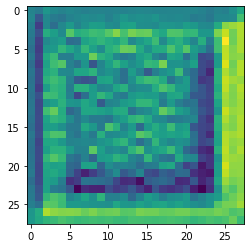

In [10]:
plt.imshow(xxx[0][0].detach().numpy())

In [7]:
np.prod(np.random.random((1,2,3,4,5)).shape)

120

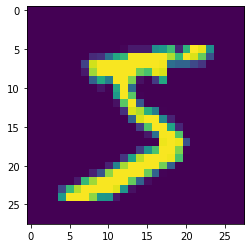

In [25]:
plt.imshow(i3._transform_input(x[0].expand(1, 3,-1,-1))[0][0].detach().numpy())

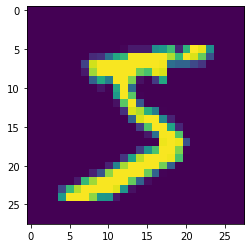

In [24]:
plt.imshow(x[0].expand(1, 3,-1,-1)[0][0].detach().numpy())

In [15]:
i3(x[0].expand(2, 3,-1,-1).resize_(2,3,299,299)).logits.shape

torch.Size([2, 1000])